In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
# from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns',100)

In [2]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\Vehicle-Loan-Default-Prediction\Data')

In [28]:
df=pd.read_csv('./train.csv')
df.head()

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [29]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [30]:
df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [31]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [32]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [33]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [34]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

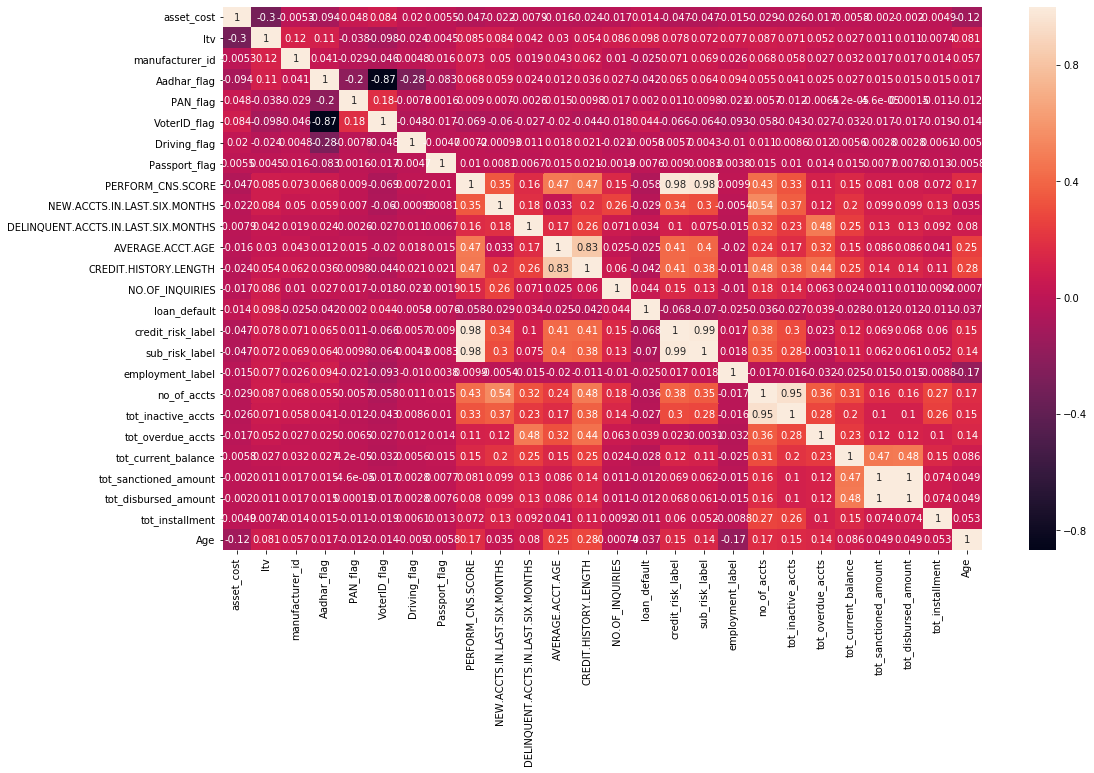

In [11]:
plt.figure(figsize=(17,10))
sns.heatmap(df.corr(),annot=True)

In [12]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment', 'Age'],
      dtype='object')

In [49]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','no_of_accts',
       'tot_overdue_accts', 'tot_current_balance',
       'tot_disbursed_amount', 'tot_installment','Age']

In [36]:
df['number_of_0'] = (df == 0).astype(int).sum(axis=1)

In [50]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])


In [15]:
df.head()

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,credit_risk_label,sub_risk_label,employment_label,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,Age,number_of_0
0,58400,89.55,45,1,0,0,0,0,0,0,0,0,0,0,0,-1,-1,1,0,0,0,0,0,0,0,34,18
1,65550,73.23,45,1,0,0,0,0,598,0,1,23,23,0,1,2,5,0,1,0,1,27600,50200,50200,1991,33,8
2,61360,89.63,45,1,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,33,19
3,66113,88.48,45,1,0,0,0,0,305,0,0,8,15,1,1,0,2,0,3,3,0,0,0,0,31,25,12
4,60300,88.39,45,1,0,0,0,0,0,0,0,0,0,1,1,-1,-1,0,0,0,0,0,0,0,0,41,17


In [37]:
numerical =['asset_cost','ltv','PERFORM_CNS.SCORE','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
            'tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment','Age']

In [17]:
df.corr()['loan_default']

asset_cost                             0.014261
ltv                                    0.098208
manufacturer_id                       -0.025039
Aadhar_flag                           -0.041593
PAN_flag                               0.002046
VoterID_flag                           0.043747
Driving_flag                          -0.005821
Passport_flag                         -0.007602
PERFORM_CNS.SCORE                     -0.057929
NEW.ACCTS.IN.LAST.SIX.MONTHS          -0.029400
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.034462
AVERAGE.ACCT.AGE                      -0.024781
CREDIT.HISTORY.LENGTH                 -0.042126
NO.OF_INQUIRIES                        0.043678
loan_default                           1.000000
credit_risk_label                     -0.067798
sub_risk_label                        -0.070454
employment_label                      -0.025377
no_of_accts                           -0.035963
tot_inactive_accts                    -0.026951
tot_overdue_accts                      0

In [62]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [60]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [53]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion='entropy',random_state=0),
    DecisionTreeClassifier(criterion='gini',random_state=0),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,n_estimators=100, max_depth=3)
]

In [63]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print("Recall :",recall_score(y_test,y_pred),"\n")
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    print("-------------------------------------------------------------------------------------------------------")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

accuracy train: 0.783238464036469 

accuracy test: 0.7834503266759117 

precision : 0.5827067669172933 

Recall : 0.010203409913764729 

f1 score: 0.02005563822216471 

-------------------------------------------------------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       rando

In [34]:
df.shape

(233154, 27)

In [35]:
df.head()

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,credit_risk_label,sub_risk_label,employment_label,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,Age,number_of_0
0,58400,89.55,45,1,0,0,0,0,0,0,0,0,0,0,0,-1,-1,1,0,0,0,0,0,0,0,34,18
1,65550,73.23,45,1,0,0,0,0,598,0,1,23,23,0,1,2,5,0,1,0,1,27600,50200,50200,1991,33,8
2,61360,89.63,45,1,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,33,19
3,66113,88.48,45,1,0,0,0,0,305,0,0,8,15,1,1,0,2,0,3,3,0,0,0,0,31,25,12
4,60300,88.39,45,1,0,0,0,0,0,0,0,0,0,1,1,-1,-1,0,0,0,0,0,0,0,0,41,17


In [36]:
df.shape

(233154, 27)

In [39]:
l=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    pvalue=ttest_ind(df1[i],df2[i])[1]
    print(pvalue)
    if pvalue>0.05:
        l.append(i)
print(l)

5.716223071536896e-12
0.0
1.869421119257312e-172
5.261091482095756e-33
4.6500173864982836e-92
3.3079399073944727e-41
1.4009500779317766e-08
2.1824831031189564e-08
2.341328916223375e-07
1.6119724395993934e-72
[]


In [39]:
numerical

['asset_cost',
 'ltv',
 'PERFORM_CNS.SCORE',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'tot_current_balance',
 'tot_sanctioned_amount',
 'tot_disbursed_amount',
 'tot_installment',
 'Age']

In [40]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment', 'Age', 'number_of_0'],
      dtype='object')

In [40]:
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','credit_risk_label', 'sub_risk_label',
       'employment_label', 'no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts','number_of_0']

In [41]:
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    if pvalue>0.05:
        l.append(i)
print(l)

['PAN_flag']


In [43]:
print("Non-significant features",l)

Non-significant features ['PAN_flag']


In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif}, index=X.columns)

,vif
asset_cost,1.193529
ltv,1.187821
manufacturer_id,10.400889
Aadhar_flag,31.110188
VoterID_flag,5.497043
Driving_flag,1.540895
Passport_flag,1.052697
PERFORM_CNS.SCORE,65.767641
NEW.ACCTS.IN.LAST.SIX.MONTHS,1.967312
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,1.533691


In [57]:
df=df.drop(['credit_risk_label','tot_sanctioned_amount','PAN_flag','tot_inactive_accts','PERFORM_CNS.SCORE'],axis=1)

KeyError: "['credit_risk_label' 'tot_sanctioned_amount' 'PAN_flag'\n 'tot_inactive_accts'] not found in axis"

In [58]:
df=df.drop('PERFORM_CNS.SCORE',axis=1)

In [55]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'sub_risk_label', 'employment_label', 'no_of_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_disbursed_amount',
       'tot_installment', 'Age', 'number_of_0'],
      dtype='object')